In [22]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
from math import sqrt

In [39]:
ticker = "IOC.NS"
start_date = '2018-01-01'
end_date = '2023-10-31'

In [25]:
df = yf.download(ticker, start=start_date, end=end_date).reset_index()
df

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-01,130.000000,130.833328,129.500000,129.983337,80.665710,6655386
1,2018-01-02,130.466660,130.933334,127.900002,128.800003,79.931343,7564734
2,2018-01-03,129.300003,129.966660,128.366669,128.766663,79.910660,7841712
3,2018-01-04,129.000000,129.449997,128.133331,129.100006,80.117516,13102707
4,2018-01-05,129.000000,129.633331,127.333336,127.949997,79.403854,9219465
...,...,...,...,...,...,...,...
1435,2023-10-23,90.300003,90.300003,87.650002,87.949997,83.678505,9592121
1436,2023-10-25,88.449997,89.199997,86.800003,87.599998,83.345505,9057651
1437,2023-10-26,87.550003,87.800003,85.500000,86.199997,82.013496,10108394
1438,2023-10-27,86.550003,87.500000,86.550003,86.900002,82.679504,6454064


In [26]:
data = df['Close']

scaler = MinMaxScaler()
data = scaler.fit_transform(data.values.reshape(-1, 1))

In [27]:
training_data_len = int(len(data) * 0.8)
training_data = data[0:training_data_len, :]
testing_data = data[training_data_len:, :]

len(training_data), len(testing_data)

(1152, 288)

In [28]:
past_values = 1

def create_training_data(data, past_values):
    if len(data) < past_values:
        return np.array([]), np.array([])
    X_train = []
    y_train = []
    for i in range(past_values, len(data)):
        X_train.append(data[i-past_values:i, 0])
        y_train.append(data[i, 0])
    return np.array(X_train), np.array(y_train)

X_train, y_train = create_training_data(training_data, past_values)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

X_test, y_test = create_training_data(testing_data, past_values)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [29]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=200, epochs=200, verbose=0)

In [30]:
pred_train = model.predict(X_train)
pred = model.predict(X_test)

9/9 [==============================] - 0s 5ms/step


In [31]:
pred_train = scaler.inverse_transform(pred_train)
pred = scaler.inverse_transform(pred)
y_test = scaler.inverse_transform([y_test])
y_train = scaler.inverse_transform([y_train])

In [32]:
y_test = y_test.flatten()
y_train = y_train.flatten()

Training Error
Mean Absolute Error (MAE): 1.2707710696965278
Root Mean Squared Error (RMSE): 1.7861712742569822


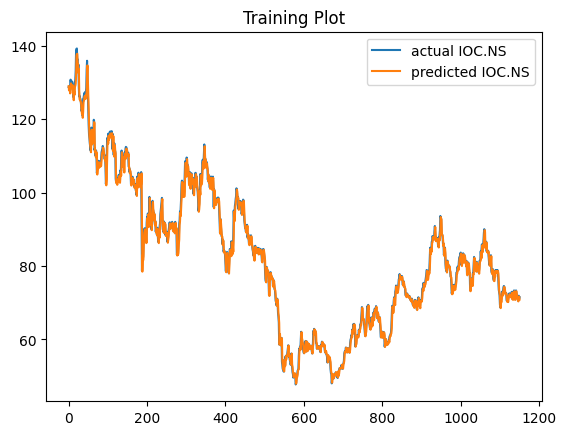

In [33]:
print("Training Error")
mae = mean_absolute_error(y_train, pred_train)
print("Mean Absolute Error (MAE):", mae)
rmse = sqrt(mean_squared_error(y_train, pred_train))
print("Root Mean Squared Error (RMSE):", rmse)
    
plt.plot(y_train, label = 'actual '+str(ticker))
plt.plot(pred_train, label = 'predicted '+str(ticker))
plt.title("Training Plot")
plt.legend()
plt.show()

Testing Error
Mean Absolute Error (MAE): 0.7827243339724661
Root Mean Squared Error (RMSE): 1.0492704574651672


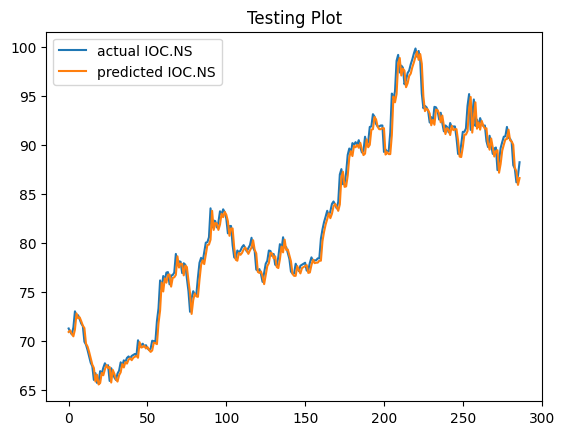

In [34]:
print("Testing Error")
mae = mean_absolute_error(y_test, pred)
print("Mean Absolute Error (MAE):", mae)
rmse = sqrt(mean_squared_error(y_test, pred))
print("Root Mean Squared Error (RMSE):", rmse)

plt.plot(y_test, label = 'actual '+str(ticker))
plt.plot(pred, label = 'predicted '+str(ticker))
plt.title("Testing Plot")
plt.legend()
plt.show()

In [35]:
y_test[-1]

88.25

In [36]:
pred[-1]

array([86.63545], dtype=float32)

In [40]:
start_date = '2023-11-01'
end_date = '2023-12-08'
future_data = yf.download(ticker, start_date, end_date).reset_index()['Close']
future_data

[*********************100%***********************]  1 of 1 completed


0      92.449997
1      95.050003
2      95.900002
3      99.000000
4     104.050003
5     103.449997
6     102.949997
7      98.050003
8      99.000000
9     101.699997
10    104.099998
11    102.699997
12    102.849998
13    101.050003
14    101.250000
15    103.800003
16    103.449997
17    108.199997
18    108.550003
19    111.750000
20    111.250000
21    115.900002
22    117.699997
23    119.300003
24    121.349998
Name: Close, dtype: float64

In [42]:
future_data = np.array(future_data)
len(future_data)

25

In [43]:
# model(april1) = (april2-pred) -> april2actual



# model(april2-pred) = april3-pred

In [44]:
def predict_future(days, last_input, future_data):
    Output = []
    i = 0
    temp = scaler.transform(future_data.reshape(-1, 1))
    
    while(i<days):
        if(len(last_input)>past_values):
            last_input = last_input[1:]
            last_input = last_input.reshape((1, past_values, 1))
            res = model.predict(last_input)
            last_input = np.append(last_input, temp[i])
            last_input = last_input[1:]
            Output.extend(res.tolist())
            i=i+1
        else:
            last_input = last_input.reshape((1, past_values, 1))
            res = model.predict(last_input)
            last_input = np.append(last_input, temp[i])
            Output.extend(res.tolist())
            i=i+1
        
    Output = scaler.inverse_transform(Output)
    return Output, last_input
    
future_predictions, last_input = predict_future(len(future_data), X_test[-1], future_data)
future_predictions = future_predictions.flatten()

1/1 [==============================] - 0s 33ms/step


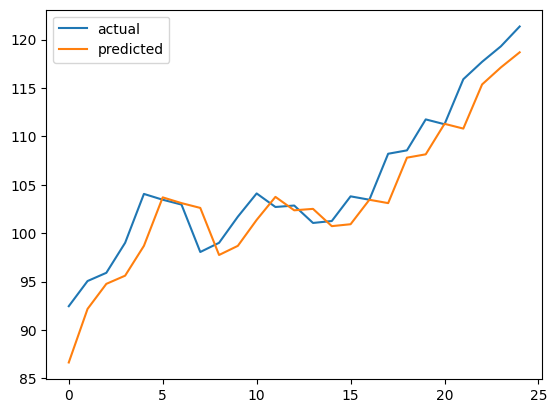

In [45]:
plt.plot(future_data, label = 'actual')
plt.plot(future_predictions, label = 'predicted')
plt.legend()
plt.show()

In [46]:
def get_control_vector(val):
    return np.diff(np.sign(np.diff(val)))

def buy_and_sell_bot(val,controls):
    inv = []
    curr_val = 1000
    inds = np.where(controls)[0]
    buy_inds = np.where(controls>0)[0]
    sell_inds = np.where(controls<0)[0]
    max_limit = sell_inds[-1] if sell_inds[-1]>buy_inds[-1] else buy_inds[-1]
    for i in range(buy_inds[0]+2):
        inv.append(curr_val)
    for i in range(buy_inds[0],max_limit+1):
        if controls[i]>0:
            buy_val = val[i+1]
        elif controls[i]<0:
            sell_val = val[i+1]
            curr_val = curr_val*sell_val/buy_val
        inv.append(curr_val)
        
    if max_limit+1!=len(controls):
        for i in range(len(controls)-max_limit-1):
            inv.append(curr_val)
    return inv

In [47]:
controls_actual = get_control_vector(future_data)
amount_actual = buy_and_sell_bot(future_data, controls_actual)

In [48]:
controls_pred= get_control_vector(future_predictions)
amount_pred = buy_and_sell_bot(future_predictions, controls_pred)

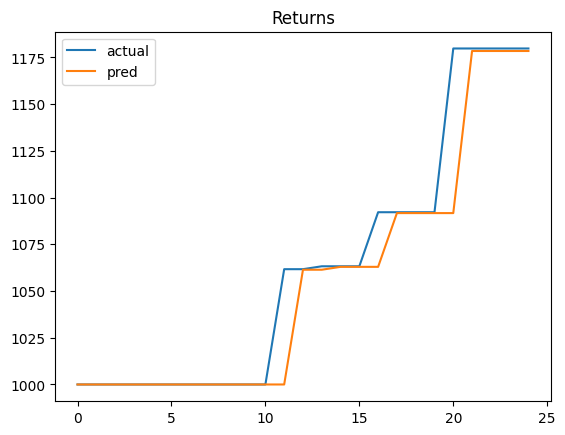

In [49]:
plt.plot(amount_actual, label="actual")
plt.plot(amount_pred, label="pred")
plt.legend()
plt.title("Returns")
plt.show()